# 1. The distribution of precipitation in SWC

In [60]:
import xarray as xr
import numpy as np
import os
import math
from scipy import ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator 
import matplotlib.dates as mdates
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
from pylab import *
import time
import datetime
from scipy import interpolate
from skimage import transform
from scipy import stats

In [61]:
precip_data = xr.open_dataset('./3B-HHR.MS.MRG.3IMERG.202104.daily.V06B.nc')
print(precip_data.precipitationCal)

<xarray.DataArray 'precipitationCal' (time: 30, lat: 1000, lon: 3600)>
[108000000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2021-04-01T12:00:00 ... 2021-04-30T12:00:00
  * lon      (lon) float32 0.05 0.15 0.25 0.35 0.45 ... 359.6 359.8 359.9 360.0
  * lat      (lat) float32 -49.95 -49.85 -49.75 -49.65 ... 49.75 49.85 49.95
Attributes:
    long_name:  Daily accumulated precipitation (combined microwave-IR) estimate
    units:      mm/hr
    lonFlip:    longitude coordinate variable has been reordered via lonFlip


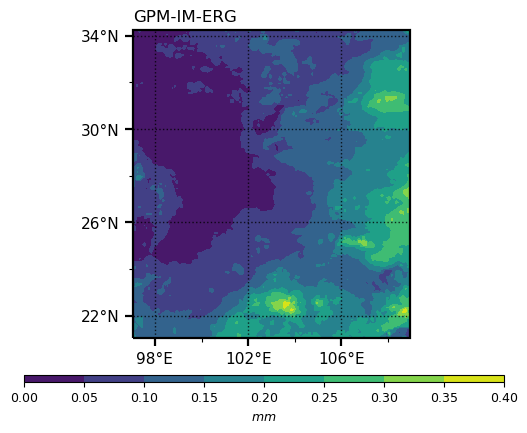

In [62]:
precip = np.asarray(precip_data.precipitationCal.loc[:,21:34.3,97:109].mean('time'))[::-1,:] # 97°–109°E, 21°–34.3°N)
latitude = precip_data.lat.loc[21:34.3][::-1]
longitude = precip_data.lon.loc[97:109]

fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
'''底图绘制'''

'''经纬度虚线设置'''
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1,
                  linestyle=':', color='k', alpha=0.8)  #设置经纬度虚线
dlon, dlat = 4, 4
xticks = np.arange(2, 162, dlon)
yticks = np.arange(2, 42, dlat)     #如此设置才可有0度线
gl.xlocator = mticker.FixedLocator(xticks) 
gl.ylocator = mticker.FixedLocator(yticks)
'''坐标轴设置成经纬度格式'''
#####这里不需要设置major_locator，因为上部分gridlines已经完成这部分工作#####
##x轴##
ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))    #将数字设置为经度格式
ax.xaxis.set_minor_locator(MultipleLocator(2))     #设置经度次格距为10的倍数
##y轴##
ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式
ax.yaxis.set_minor_locator(MultipleLocator(2))      #设置纬度次格距为5的倍数
'''contour 作图'''
ax_c = ax.contourf(longitude, latitude, precip)
'''set colorbar'''
ax_cb = fig.add_axes([0.1, 0, 0.8, 0.018])     #creat a subplot for colobar
##[left starting point, bottom starting point, length, width] unit:pixels
cb = fig.colorbar(ax_c,cax=ax_cb,orientation='horizontal',spacing='proportional')
cb.set_label('$mm$', fontsize=9)
cb.ax.tick_params(labelsize=9)  #设置色标刻度字体大小
'''优化图片边框、坐标轴粗细''' 
ax.spines['geo'].set_linewidth('1.6')    #地图加粗边框与普通的plt不一样
ax.tick_params(axis='both', which='major', width=1.6, length=6)   #加粗主坐标轴刻度线粗细、长度
ax.tick_params(axis='both', which='minor', width=0.8, length=3)
'''name the sequence'''
ax.set_title('GPM-IM-ERG', loc='left')
ax.tick_params(labelsize=11)    #fonrsize

# 2. Mask data depending on the boundry in Python

Reference: https://mp.weixin.qq.com/s/HwtoUMk56ZlUX5P0At_WtQ  
The latitude should be sorted in descending order.

In [63]:
'''Function of mask by employing shp-file'''
from osgeo import gdal,osr,ogr
def makeMask(lon,lat,res,shapefile):
    source_ds = ogr.Open(shapefile)
    source_layer = source_ds.GetLayer()
 
    # Create high res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', lon.size, lat.size, gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), res, 0, lat.max(), 0, -res))
    band = mem_ds.GetRasterBand(1)
 
    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])
 
    # Get rasterized shapefile as numpy array
    array = band.ReadAsArray()
 
    # Flush memory file
    mem_ds = None
    band = None
    return array

## 2.1 Make the mask

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Warning 1: Failed to fetch spatial reference on layer 地理信息图层_省界 to build transformer, assuming matching coordinate systems.


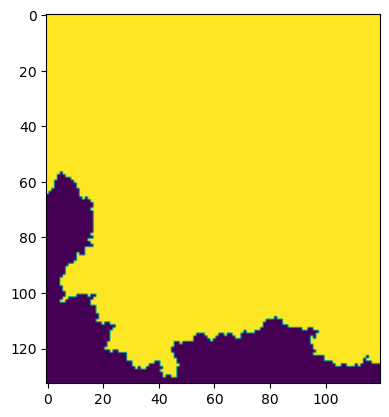

In [73]:
shapefile = '/Users/harvey/Desktop/Personal Data/Python File/Shp/China_shp/地理信息图层_省界.shp'  #shp-file of China
cellsize = longitude[:][1] - longitude[:][0]
china_mask = makeMask(longitude,latitude,cellsize,shapefile)
plt.imshow(china_mask)
print(china_mask)

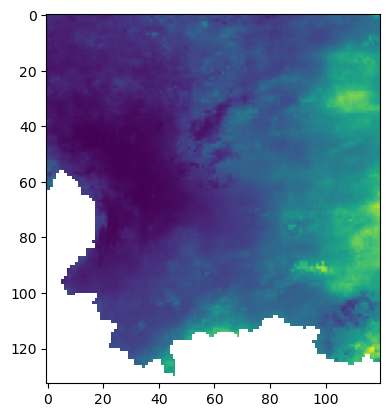

In [65]:
precip_mask = np.ma.masked_where(china_mask==0,precip)
plt.imshow(precip_mask)
plt.show()

## 2.2 Application of mask

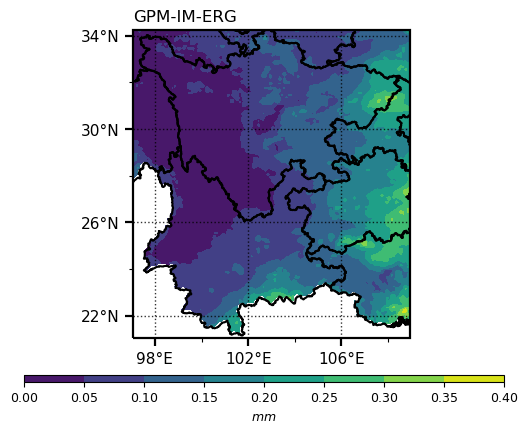

In [66]:
fig = plt.figure(figsize=(6,4), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
'''底图绘制'''
shp_province = shpreader.Reader(shapefile)
ax.add_geometries(shp_province.geometries(), crs=ccrs.PlateCarree(), facecolor='none',edgecolor='k',linewidth=1.5)
'''经纬度虚线设置'''
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1,
                  linestyle=':', color='k', alpha=0.8)  #设置经纬度虚线
dlon, dlat = 4, 4
xticks = np.arange(2, 162, dlon)
yticks = np.arange(2, 42, dlat)     #如此设置才可有0度线
gl.xlocator = mticker.FixedLocator(xticks) 
gl.ylocator = mticker.FixedLocator(yticks)
'''坐标轴设置成经纬度格式'''
#####这里不需要设置major_locator，因为上部分gridlines已经完成这部分工作#####
##x轴##
ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))    #将数字设置为经度格式
ax.xaxis.set_minor_locator(MultipleLocator(2))     #设置经度次格距为10的倍数
##y轴##
ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式
ax.yaxis.set_minor_locator(MultipleLocator(2))      #设置纬度次格距为5的倍数
'''contour 作图'''
ax_c = ax.contourf(longitude, latitude, precip_mask)
'''set colorbar'''
ax_cb = fig.add_axes([0.1, 0, 0.8, 0.018])     #creat a subplot for colobar
##[left starting point, bottom starting point, length, width] unit:pixels
cb = fig.colorbar(ax_c,cax=ax_cb,orientation='horizontal',spacing='proportional')
cb.set_label('$mm$', fontsize=9)
cb.ax.tick_params(labelsize=9)  #设置色标刻度字体大小
'''优化图片边框、坐标轴粗细''' 
ax.spines['geo'].set_linewidth('1.6')    #地图加粗边框与普通的plt不一样
ax.tick_params(axis='both', which='major', width=1.6, length=6)   #加粗主坐标轴刻度线粗细、长度
ax.tick_params(axis='both', which='minor', width=0.8, length=3)
'''name the sequence'''
ax.set_title('GPM-IM-ERG', loc='left')
ax.tick_params(labelsize=11)    #fontsize

# 3. Classify precipitation in SWC via K-means clustering depending on R95

In [74]:
R95_data = xr.open_dataset('./R95.nc')
print(R95_data)
R95 = np.asarray(R95_data.R95)
longitude = np.asarray(R95_data.lon)
latitude = np.asarray(R95_data.lat)

<xarray.Dataset>
Dimensions:  (lat: 133, lon: 120)
Coordinates:
  * lat      (lat) float64 34.25 34.15 34.05 33.95 ... 21.35 21.25 21.15 21.05
  * lon      (lon) float64 97.05 97.15 97.25 97.35 ... 108.7 108.8 108.8 108.9
Data variables:
    R95      (lat, lon) float64 ...


## 3.1 Mask the points out of China  
Classifying the preicpitation in SWC should rule out the points in China

Warning 1: Failed to fetch spatial reference on layer 地理信息图层_省界 to build transformer, assuming matching coordinate systems.


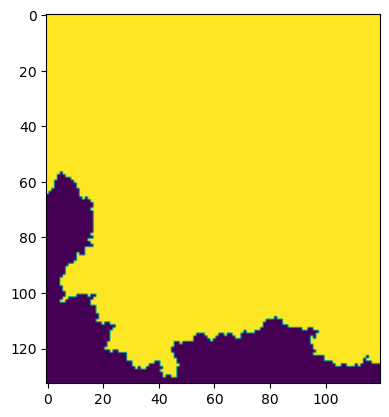

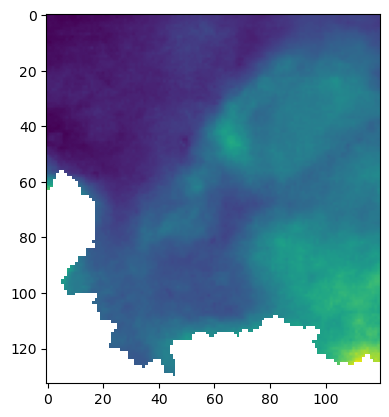

In [68]:
shapefile = '/Users/harvey/Desktop/Personal Data/Python File/Shp/China_shp/地理信息图层_省界.shp'  #shp-file of China

cellsize = longitude[:][1] - longitude[:][0]
china_mask = makeMask(longitude,latitude,cellsize,shapefile)
plt.imshow(china_mask)
plt.show()
R95_mask = np.ma.masked_where(china_mask==0, R95)
plt.imshow(R95_mask)
plt.show()

## 3.2 K-means clustering

In [69]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle

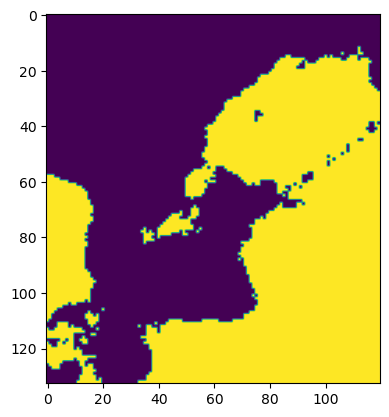

In [70]:
'''K-means clustering by R95'''
R95_samples = np.reshape(R95, (R95.shape[0]*R95.shape[1],1))
model = KMeans(n_clusters=2) 
R95_kmeans = model.fit(R95_samples)
R95_labels = np.reshape(R95_kmeans.labels_, R95.shape)
plt.imshow(R95_labels)
plt.show()

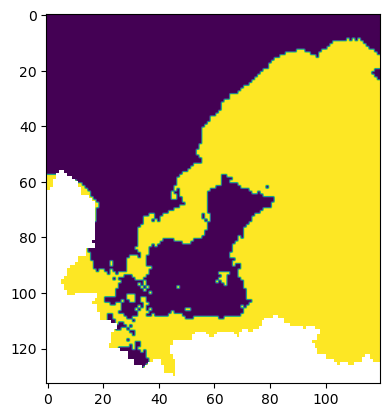

In [71]:
'''K-means clustering by R95_mask'''
R95_samples = np.reshape(R95_mask[R95_mask.mask==False], 
                         (R95_mask[R95_mask.mask==False].shape[0],1))
model = KMeans(n_clusters=2) 
R95_kmeans = model.fit(R95_samples)
R95_labels = R95_kmeans.labels_
'''Mapping the labels to the points in SWC'''
rows, columns = np.where(R95_mask.mask==False)
SWC_labels = R95_mask.copy()
for i in range(R95_labels.shape[0]):
    row = rows[i]
    column = columns[i]
    SWC_labels[row, column] = R95_labels[i]
plt.imshow(SWC_labels)
plt.show()   
    

## 3.3 Draw the picture of the result of K-means clustering by R95_mask

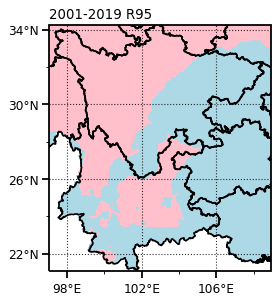

In [72]:
fig = plt.figure(figsize=(6,4), dpi=80)
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
'''底图绘制'''
shp_province = shpreader.Reader(shapefile)
ax.add_geometries(shp_province.geometries(), crs=ccrs.PlateCarree(), facecolor='none',edgecolor='k',linewidth=1.5)
'''经纬度虚线设置'''
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1,
                  linestyle=':', color='k', alpha=0.8)  #设置经纬度虚线
dlon, dlat = 4, 4
xticks = np.arange(2, 162, dlon)
yticks = np.arange(2, 42, dlat)     #如此设置才可有0度线
gl.xlocator = mticker.FixedLocator(xticks) 
gl.ylocator = mticker.FixedLocator(yticks)
'''坐标轴设置成经纬度格式'''
#####这里不需要设置major_locator，因为上部分gridlines已经完成这部分工作#####
##x轴##
ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))    #将数字设置为经度格式
ax.xaxis.set_minor_locator(MultipleLocator(2))     #设置经度次格距为10的倍数
##y轴##
ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式
ax.yaxis.set_minor_locator(MultipleLocator(2))      #设置纬度次格距为5的倍数
'''contourf 作图'''
ax_c = ax.contourf(longitude, latitude, SWC_labels,levels=[0,0.5,1], colors=['#FFC0CB', '#ADD8E6'])
# This is the fix for the white lines between contour levels
for c in ax_c.collections:
    c.set_edgecolor("face")
'''优化图片边框、坐标轴粗细''' 
ax.spines['geo'].set_linewidth('1.6')    #地图加粗边框与普通的plt不一样
ax.tick_params(axis='both', which='major', width=1.6, length=6)   #加粗主坐标轴刻度线粗细、长度
ax.tick_params(axis='both', which='minor', width=0.8, length=3)
'''name the sequence'''
ax.set_title('2001-2019 R95', loc='left')
ax.tick_params(labelsize=11)    #fontsize
plt.savefig('./R95.pdf', bbox_inches='tight')
plt.show()

# 4. Application of K-means clustering in classifying ENSO